<a href="https://colab.research.google.com/github/asyhar22/kalbe_farma_ds/blob/main/VIX_Kalbe_Nutritionals_ARIMA_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##Data

In [2]:
file_url = "https://github.com/asyhar22/kalbe_farma_ds/raw/main/DATA/merged_data.xlsx"

In [3]:
df = pd.read_excel(file_url)
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,Crackers,7500,36,0,Married,10.53,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR16356,165,01/01/2022,P9,10000,7,70000,1,Yoghurt,10000,44,1,Married,14.58,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
2,TR1984,183,01/01/2022,P1,8800,4,35200,4,Choco Bar,8800,27,1,Single,0.18,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR35256,160,01/01/2022,P1,8800,7,61600,4,Choco Bar,8800,48,1,Married,12.57,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR41231,386,01/01/2022,P9,10000,1,10000,4,Yoghurt,10000,33,0,Married,6.95,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
y = df.groupby(['Date'])['Qty'].sum()
y = pd.DataFrame(y)
y.head()

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


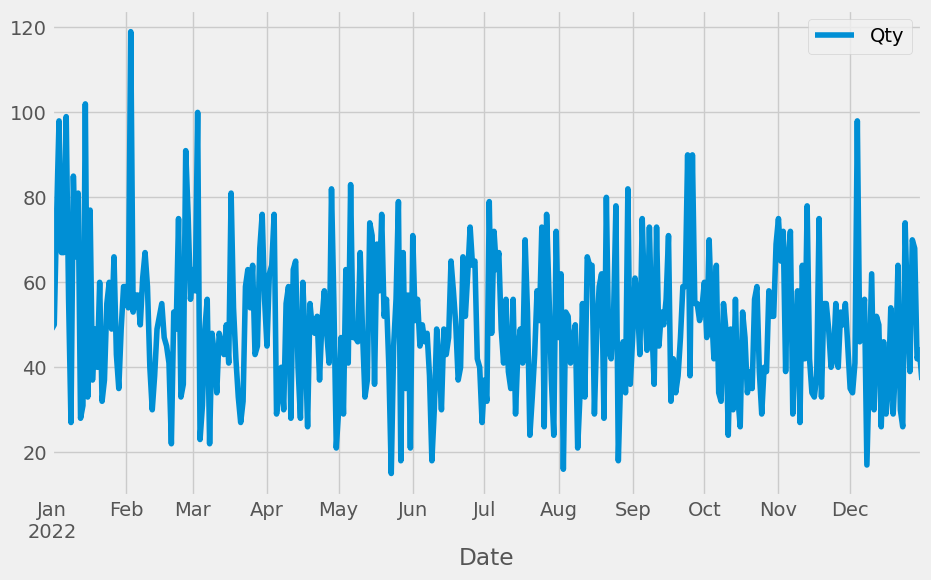

In [5]:
y.plot(figsize=(10, 6))
plt.show()

##EDA

In [6]:
adf_test = adfuller(y)

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

# Check for stationarity based on the p-value
if adf_test[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -19.018782802299725
p-value: 0.0
Critical Values:
   1%: -3.4484434475193777
   5%: -2.869513170510808
   10%: -2.571017574266393
The time series is likely stationary.


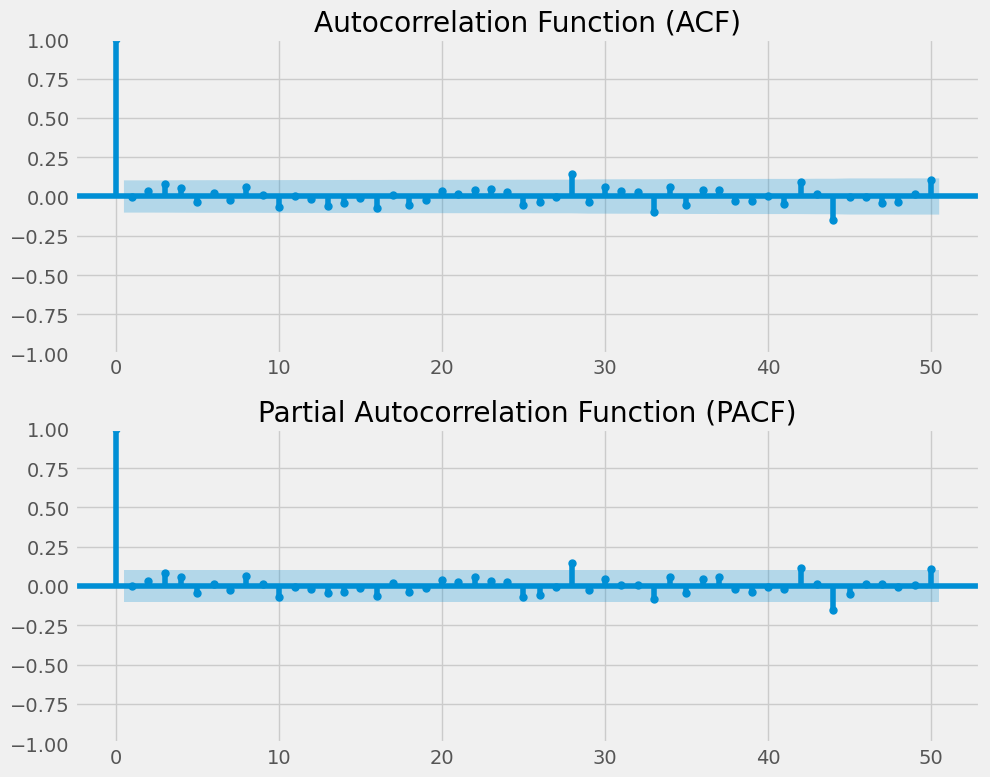

In [7]:
# set up plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# plot auto correlation function
plot_acf(y, ax=ax[0], lags=50)
ax[0].set_title('Autocorrelation Function (ACF)')

# plot partial auto correlation function
plot_pacf(y, ax=ax[1], lags=50)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

# show plot
plt.tight_layout()
plt.show()

##Train Test Split

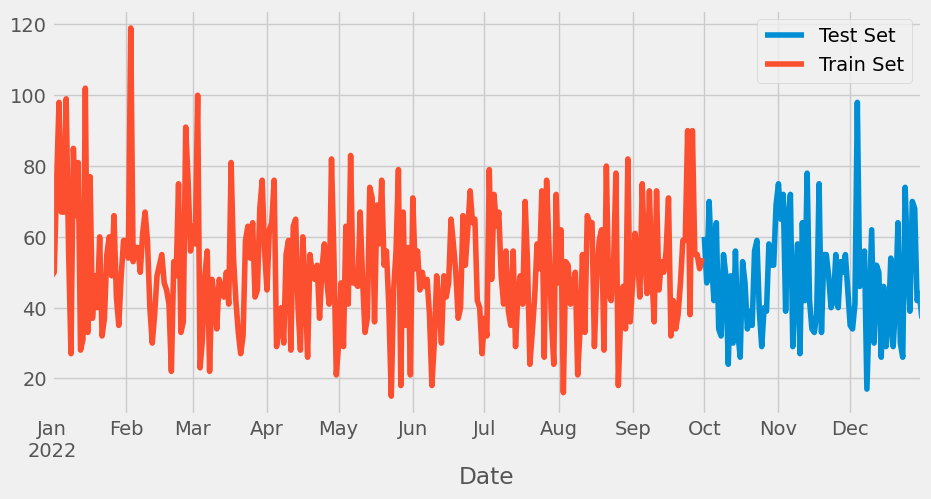

In [8]:
split_date = '2022-10-01'
y_train = y.loc[y.index < split_date].copy()
y_test = y.loc[y.index >= split_date].copy()

y_test.rename(columns={'Qty':'Test Set'}).join(y_train.rename(columns={'Qty':'Train Set'}), how='outer').plot(figsize=(10,5))

plt.show()

##ARIMA Model

In [9]:
# The data is stationery
d = 0
# AR order
p = 3
# MA order
q = 3

mod = sm.tsa.ARIMA(y, order=(p,d,q))
results = mod.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  365
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1541.492
Date:                Tue, 15 Aug 2023   AIC                           3098.984
Time:                        06:29:01   BIC                           3130.183
Sample:                    01-01-2022   HQIC                          3111.383
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1447      0.970     51.709      0.000      48.244      52.045
ar.L1          0.0785      0.046      1.711      0.087      -0.011       0.168
ar.L2          0.1611      0.053      3.043      0.0

In [10]:
y_pred = results.predict(split_date,'2022-12-31')
y_pred

2022-10-01    50.893816
2022-10-02    48.015612
2022-10-03    49.252313
2022-10-04    49.046316
2022-10-05    52.485354
                ...    
2022-12-27    52.902204
2022-12-28    52.940136
2022-12-29    50.295497
2022-12-30    49.758077
2022-12-31    48.226599
Freq: D, Name: predicted_mean, Length: 92, dtype: float64

##Actual vs Forecast

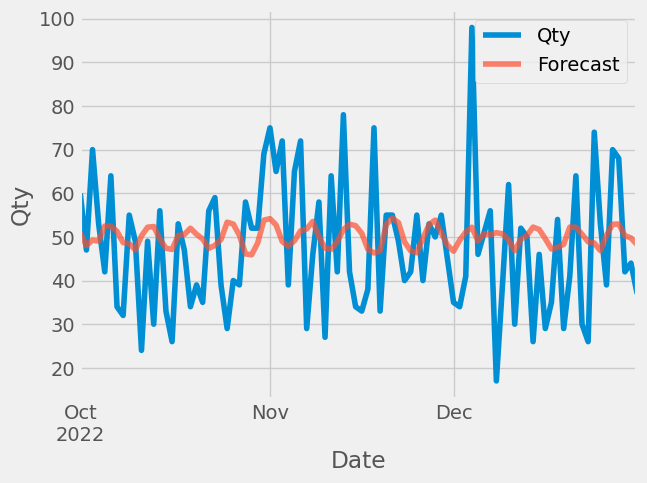

In [11]:
ax = y_test.plot(label='Original')
y_pred.plot(ax=ax, label='Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Qty')
plt.legend()

plt.show()

##Evaluation

In [12]:
np.sqrt(mean_squared_error(y_true=y_test['Qty'],y_pred=y_pred))

14.960560202121865

In [13]:
mean_absolute_error(y_true=y_test['Qty'],y_pred=y_pred)

12.45052637045621

In [14]:
mean_absolute_percentage_error(y_true=y_test['Qty'],y_pred=y_pred)

31.246860606705717